# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

In [ ]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests
import geoviews as gv
import geoviews.feature as gf
from geoviews import opts

# Import API key
from api_keys import geoapify_key

hvplot is installed!


In [8]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("../WeatherPy/output_data/cities.csv")

# Or convert Max Temp from Kelvin to Fahrenheit
city_data_df['Max Temp'] = city_data_df['Max Temp'] * 9/5 - 459.67

# Display sample data
city_data_df.head()

City_ID                         City      Lat       Lng  Max Temp  \
0        0  edinburgh of the seven seas -37.0676  -12.3116    54.734   
1        1                    grytviken -54.2811  -36.5092    35.618   
2        2                   fort bragg  35.1390  -79.0060    60.350   
3        3                 quatre cocos -20.2078   57.7625    76.082   
4        4                   kingscliff -28.2667  153.5667    70.772   

   Humidity  Cloudiness  Wind Speed Country        Date  
0        74         100        7.64      SH  1697597016  
1        88          86        5.39      GS  1697596702  
2        85         100        0.00      US  1697597016  
3        85          43        3.04      MU  1697597016  
4        77         100        6.17      AU  1697597016

---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

In [ ]:
#%%capture --no-display

plot = city_data_df.hvplot.Points('Lng', 'Lat',
                          geo=True, tiles='OSM',
                          color='Humidity', size='Humidity',
                          hover_cols=['City'])
plot


### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [12]:
# Filter for cities with max temp between 65 and 75 degrees Fahrenheit
ideal_cities_df = city_data_df[(city_data_df['Max Temp'] >= 65) & (city_data_df['Max Temp'] <= 75)]

# Drop any rows with null values
ideal_cities_df = ideal_cities_df.dropna()

# Display the DataFrame
ideal_cities_df

City_ID          City      Lat       Lng  Max Temp  Humidity  Cloudiness  \
4          4    kingscliff -28.2667  153.5667    70.772        77         100   
9          9  east ballina -28.8667  153.5833    66.794        57          98   
12        12    woolgoolga -30.1106  153.2007    69.674        52          91   
16        16     adamstown -25.0660 -130.1015    71.870        88         100   
19        19      belmonte -15.8631  -38.8828    72.770        80          60   
..       ...           ...      ...       ...       ...       ...         ...   
571      571         dunda  -8.1167   34.2500    67.928        66          86   
572      572         crane  31.3974 -102.3501    67.280        34           0   
573      573       narwana  29.6167   76.1167    71.600        50           0   
574      574        bozoum   6.3193   16.3799    68.900        95          97   
578      578  port hueneme  34.1478 -119.1951    73.274        87         100   

     Wind Speed Country        Date  
4          6.17      AU  1697597016  
9          7.21      AU  1697597017  
12         6.90      AU  1697597018  
16         3.04      PN  1697597013  
19         1.93      BR  1697597019  
..          ...     ...         ...  
571        1.27      TZ  1697597114  
572        8.46      US  1697597114  
573        2.14      IN  1697597115  
574        0.60      CF  1697597115  
578        1.34      US  1697597115  

[121 rows x 10 columns]

### Step 3: Create a new DataFrame called `hotel_df`.

In [13]:
# Create a new DataFrame called hotel_df
hotel_df = city_data_df[['City', 'Country', 'Lat', 'Lng', 'Humidity']].copy()

# Add an empty "Hotel Name" column
hotel_df['Hotel Name'] = ""

# Display the DataFrame
hotel_df


City Country      Lat       Lng  Humidity  \
0    edinburgh of the seven seas      SH -37.0676  -12.3116        74   
1                      grytviken      GS -54.2811  -36.5092        88   
2                     fort bragg      US  35.1390  -79.0060        85   
3                   quatre cocos      MU -20.2078   57.7625        85   
4                     kingscliff      AU -28.2667  153.5667        77   
..                           ...     ...      ...       ...       ...   
575                       fuling      CN  29.7022  107.3919        55   
576                   abra pampa      AR -22.7205  -65.6970        72   
577                      dongkan      CN  33.9997  119.8308        41   
578                 port hueneme      US  34.1478 -119.1951        87   
579                   punta alta      AR -38.8759  -62.0736        41   

    Hotel Name  
0               
1               
2               
3               
4               
..         ...  
575             
576             
577             
578             
579             

[580 rows x 6 columns]

### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [15]:
radius = 100  # Define the radius
params = {
    "apiKey": geoapify_key,
    "format": "json",
    "limit": 1,
    "radius": radius,
    "categories": "hotel",
    "lang": "en"
}

# Print a message to follow up the hotel search
print("Starting hotel search")

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iterrows():
    # Get latitude, longitude from the DataFrame
    lat = row['Lat']
    lon = row['Lng']

    # Add filter and bias parameters with the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{lon},{lat},{radius}"
    params["bias"] = f"circle:{lon},{lat},{radius}"

    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"

    # Make an API request using the params dictionary
    response = requests.get(base_url, params=params)

    # Convert the API response to JSON format
    name_address = response.json()

    # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        hotel_df.loc[index, "Hotel Name"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel Name"] = "No hotel found"

    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel Name']}")

# Display sample data
hotel_df

Starting hotel search
edinburgh of the seven seas - nearest hotel: No hotel found
grytviken - nearest hotel: No hotel found
fort bragg - nearest hotel: No hotel found
quatre cocos - nearest hotel: No hotel found
kingscliff - nearest hotel: No hotel found
taltal - nearest hotel: No hotel found
south hedland - nearest hotel: No hotel found
tsengel - nearest hotel: No hotel found
bethel - nearest hotel: No hotel found
east ballina - nearest hotel: No hotel found
yellowknife - nearest hotel: No hotel found
badger - nearest hotel: No hotel found
woolgoolga - nearest hotel: No hotel found
margaret river - nearest hotel: No hotel found
saldanha - nearest hotel: No hotel found
ola - nearest hotel: No hotel found
adamstown - nearest hotel: No hotel found
novo aripuana - nearest hotel: No hotel found
miyaly - nearest hotel: No hotel found
belmonte - nearest hotel: No hotel found
puerto natales - nearest hotel: No hotel found
college - nearest hotel: No hotel found
mili - nearest hotel: No hotel 

albufeira - nearest hotel: No hotel found
saynshand - nearest hotel: No hotel found
port moresby - nearest hotel: No hotel found
mbeni - nearest hotel: No hotel found
tindouf - nearest hotel: No hotel found
morehead city - nearest hotel: No hotel found
nadym - nearest hotel: No hotel found
leava - nearest hotel: No hotel found
morondava - nearest hotel: No hotel found
el calafate - nearest hotel: No hotel found
san antonio - nearest hotel: No hotel found
gadzhiyevo - nearest hotel: No hotel found
port lincoln - nearest hotel: No hotel found
molchanovo - nearest hotel: No hotel found
urangan - nearest hotel: No hotel found
alcains - nearest hotel: No hotel found
rawah - nearest hotel: No hotel found
nagqu - nearest hotel: No hotel found
beira - nearest hotel: No hotel found
prado - nearest hotel: No hotel found
posto fiscal rolim de moura - nearest hotel: No hotel found
colonia - nearest hotel: No hotel found
el porvenir - nearest hotel: No hotel found
belyy yar - nearest hotel: No hote

gulariya - nearest hotel: No hotel found
labytnangi - nearest hotel: No hotel found
sortavala - nearest hotel: No hotel found
pamandzi - nearest hotel: No hotel found
oroqen zizhiqi - nearest hotel: No hotel found
anadyr - nearest hotel: No hotel found
tougue - nearest hotel: No hotel found
poltavka - nearest hotel: No hotel found
pizarro - nearest hotel: No hotel found
nogliki - nearest hotel: No hotel found
lebu - nearest hotel: No hotel found
hobyo - nearest hotel: No hotel found
shahrak - nearest hotel: No hotel found
kapa'a - nearest hotel: No hotel found
beohari - nearest hotel: No hotel found
biltine - nearest hotel: No hotel found
achacachi - nearest hotel: No hotel found
flying fish cove - nearest hotel: No hotel found
sao jose da coroa grande - nearest hotel: No hotel found
san pedro - nearest hotel: No hotel found
benghazi - nearest hotel: No hotel found
madimba - nearest hotel: No hotel found
greymouth - nearest hotel: No hotel found
alae - nearest hotel: No hotel found
lay

City Country      Lat       Lng  Humidity  \
0    edinburgh of the seven seas      SH -37.0676  -12.3116        74   
1                      grytviken      GS -54.2811  -36.5092        88   
2                     fort bragg      US  35.1390  -79.0060        85   
3                   quatre cocos      MU -20.2078   57.7625        85   
4                     kingscliff      AU -28.2667  153.5667        77   
..                           ...     ...      ...       ...       ...   
575                       fuling      CN  29.7022  107.3919        55   
576                   abra pampa      AR -22.7205  -65.6970        72   
577                      dongkan      CN  33.9997  119.8308        41   
578                 port hueneme      US  34.1478 -119.1951        87   
579                   punta alta      AR -38.8759  -62.0736        41   

         Hotel Name  
0    No hotel found  
1    No hotel found  
2    No hotel found  
3    No hotel found  
4    No hotel found  
..              ...  
575  No hotel found  
576  No hotel found  
577  No hotel found  
578  No hotel found  
579  No hotel found  

[580 rows x 6 columns]

### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
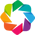

C:\Users\johns\AppData\Roaming\Python\Python311\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\johns\AppData\Roaming\Python\Python311\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


:Overlay
   .Ocean.I  :Feature   [Longitude,Latitude]
   .Land.I   :Feature   [Longitude,Latitude]
   .Points.I :Points   [Lng,Lat]   (City,Country,Humidity,Hotel Name)

In [18]:
#%%capture --no-display

import geoviews as gv
import geoviews.feature as gf
from geoviews import opts
from bokeh.models import HoverTool

gv.extension('bokeh')

# Create a Points object with the latitude and longitude
points = gv.Points(hotel_df, ['Lng', 'Lat'])

# Define the hover tool tips
hover = HoverTool(tooltips=[
    ("City", "@City"),
    ("Hotel Name", "@{Hotel Name}"),
    ("Country", "@Country")
])

# Create the map
map_options = opts.Points(global_extent=True, tools=[hover], width=600, height=400)
(gf.ocean * gf.land * points).opts(map_options)
